# DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

## Generator

In [2]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')

    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [3]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

## Datasets

In [4]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

Shuffling and writing examples to C:\/Users/min/tensorflow_datasets/fashion_mnist/3.0.1.incompleteI3EJE5/fashion_mnist-train.tfrecord


Shuffling and writing examples to C:\/Users/min/tensorflow_datasets/fashion_mnist/3.0.1.incompleteI3EJE5/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to C:\Users\min\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


## Model, Optimizers

In [5]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [6]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [7]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

epoch: 1, d_loss: 1.4074069261550903, g_loss: 0.7731058597564697


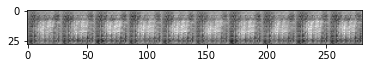

epoch: 2, d_loss: 1.260125994682312, g_loss: 0.9515433311462402
epoch: 3, d_loss: 1.2310619354248047, g_loss: 0.956710159778595
epoch: 4, d_loss: 1.222372055053711, g_loss: 0.94227534532547
epoch: 5, d_loss: 1.2136355638504028, g_loss: 0.9424519538879395
epoch: 6, d_loss: 1.1920056343078613, g_loss: 0.9442210793495178
epoch: 7, d_loss: 1.1956058740615845, g_loss: 0.9528786540031433
epoch: 8, d_loss: 1.1873430013656616, g_loss: 0.966214120388031
epoch: 9, d_loss: 1.1907618045806885, g_loss: 0.9693053364753723
epoch: 10, d_loss: 1.1971030235290527, g_loss: 0.967585563659668
epoch: 11, d_loss: 1.178217887878418, g_loss: 0.971993088722229


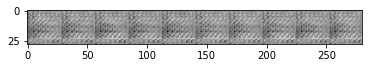

epoch: 12, d_loss: 1.2116484642028809, g_loss: 0.9262394309043884
epoch: 13, d_loss: 1.18907630443573, g_loss: 0.9834166169166565
epoch: 14, d_loss: 1.1200580596923828, g_loss: 1.1044743061065674
epoch: 15, d_loss: 1.255458950996399, g_loss: 1.0172353982925415
epoch: 16, d_loss: 1.1806164979934692, g_loss: 1.0167696475982666
epoch: 17, d_loss: 1.0296909809112549, g_loss: 1.1120935678482056
epoch: 18, d_loss: 1.1035007238388062, g_loss: 1.1454002857208252
epoch: 19, d_loss: 1.2691770792007446, g_loss: 1.030827283859253
epoch: 20, d_loss: 1.2739957571029663, g_loss: 0.9928013682365417
epoch: 21, d_loss: 1.2627464532852173, g_loss: 0.9755977988243103


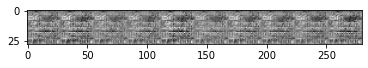

epoch: 22, d_loss: 1.262421727180481, g_loss: 0.9666781425476074
epoch: 23, d_loss: 1.2824795246124268, g_loss: 0.9390279650688171
epoch: 24, d_loss: 1.2721750736236572, g_loss: 0.9265392422676086
epoch: 25, d_loss: 1.2943276166915894, g_loss: 0.915045440196991
epoch: 26, d_loss: 1.2684249877929688, g_loss: 0.9071703553199768
epoch: 27, d_loss: 1.2922109365463257, g_loss: 0.8867630958557129
epoch: 28, d_loss: 1.286010980606079, g_loss: 0.8808791637420654
epoch: 29, d_loss: 1.2967145442962646, g_loss: 0.8691820502281189
epoch: 30, d_loss: 1.3836266994476318, g_loss: 0.7975303530693054
epoch: 31, d_loss: 1.3619979619979858, g_loss: 0.7893956303596497


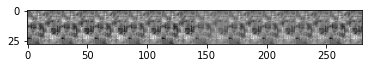

epoch: 32, d_loss: 1.0867632627487183, g_loss: 0.9995286464691162
epoch: 33, d_loss: 1.0848475694656372, g_loss: 1.1802716255187988
epoch: 34, d_loss: 1.0595412254333496, g_loss: 1.2140346765518188
epoch: 35, d_loss: 1.0924415588378906, g_loss: 1.206158995628357
epoch: 36, d_loss: 1.144422173500061, g_loss: 1.1568573713302612
epoch: 37, d_loss: 1.2887506484985352, g_loss: 1.0318348407745361
epoch: 38, d_loss: 1.3433228731155396, g_loss: 0.7970296740531921
epoch: 39, d_loss: 1.3541899919509888, g_loss: 0.7445123195648193
epoch: 40, d_loss: 1.3523151874542236, g_loss: 0.7521419525146484
epoch: 41, d_loss: 1.342308521270752, g_loss: 0.7534547448158264


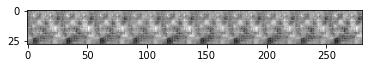

epoch: 42, d_loss: 1.36754310131073, g_loss: 0.7173333168029785
epoch: 43, d_loss: 1.3107308149337769, g_loss: 0.7940372824668884
epoch: 44, d_loss: 1.2966763973236084, g_loss: 0.808047890663147
epoch: 45, d_loss: 1.3034135103225708, g_loss: 0.8101841807365417
epoch: 46, d_loss: 1.2917872667312622, g_loss: 0.815960705280304
epoch: 47, d_loss: 1.2728569507598877, g_loss: 0.8350047469139099
epoch: 48, d_loss: 1.260917067527771, g_loss: 0.8594748973846436
epoch: 49, d_loss: 1.252967357635498, g_loss: 0.8827273845672607
epoch: 50, d_loss: 1.2351670265197754, g_loss: 0.8963287472724915
epoch: 51, d_loss: 1.2832974195480347, g_loss: 0.8637028932571411


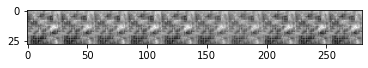

epoch: 52, d_loss: 1.3482391834259033, g_loss: 0.7842200994491577
epoch: 53, d_loss: 1.3442775011062622, g_loss: 0.7528696060180664
epoch: 54, d_loss: 1.3415710926055908, g_loss: 0.7541605830192566
epoch: 55, d_loss: 1.337943434715271, g_loss: 0.7571483850479126
epoch: 56, d_loss: 1.3335689306259155, g_loss: 0.7578302025794983
epoch: 57, d_loss: 1.3276348114013672, g_loss: 0.7679438591003418
epoch: 58, d_loss: 1.2962461709976196, g_loss: 0.8004541397094727
epoch: 59, d_loss: 1.3172603845596313, g_loss: 0.7918016314506531
epoch: 60, d_loss: 1.3106008768081665, g_loss: 0.7941744923591614
epoch: 61, d_loss: 1.3132861852645874, g_loss: 0.7903797030448914


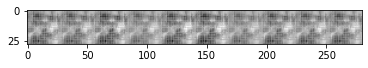

epoch: 62, d_loss: 1.3030160665512085, g_loss: 0.8037737607955933
epoch: 63, d_loss: 1.3053395748138428, g_loss: 0.7987186312675476
epoch: 64, d_loss: 1.3021851778030396, g_loss: 0.8058647513389587
epoch: 65, d_loss: 1.3024661540985107, g_loss: 0.8055170178413391
epoch: 66, d_loss: 1.2950341701507568, g_loss: 0.8083606958389282
epoch: 67, d_loss: 1.3015929460525513, g_loss: 0.8091421127319336
epoch: 68, d_loss: 1.3022173643112183, g_loss: 0.8090451955795288
epoch: 69, d_loss: 1.3041831254959106, g_loss: 0.8055179119110107
epoch: 70, d_loss: 1.303235411643982, g_loss: 0.8055194020271301
epoch: 71, d_loss: 1.3008573055267334, g_loss: 0.8080759644508362


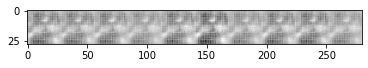

epoch: 72, d_loss: 1.3003218173980713, g_loss: 0.8069279789924622
epoch: 73, d_loss: 1.3059827089309692, g_loss: 0.8016113638877869
epoch: 74, d_loss: 1.2979539632797241, g_loss: 0.8076656460762024
epoch: 75, d_loss: 1.2947090864181519, g_loss: 0.8200029134750366
epoch: 76, d_loss: 1.3056046962738037, g_loss: 0.8121348023414612
epoch: 77, d_loss: 1.3404299020767212, g_loss: 0.7574032545089722
epoch: 78, d_loss: 1.3150153160095215, g_loss: 0.776706874370575
epoch: 79, d_loss: 1.322670578956604, g_loss: 0.7753351330757141
epoch: 80, d_loss: 1.3168070316314697, g_loss: 0.7768831253051758
epoch: 81, d_loss: 1.3407472372055054, g_loss: 0.764501690864563


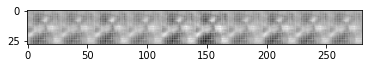

epoch: 82, d_loss: 1.3336912393569946, g_loss: 0.7615706920623779
epoch: 83, d_loss: 1.3480985164642334, g_loss: 0.7523859143257141
epoch: 84, d_loss: 1.3351622819900513, g_loss: 0.7605165839195251
epoch: 85, d_loss: 1.3693815469741821, g_loss: 0.7307890057563782
epoch: 86, d_loss: 1.3842400312423706, g_loss: 0.7058833837509155
epoch: 87, d_loss: 1.2107115983963013, g_loss: 0.8592479228973389
epoch: 88, d_loss: 1.0093469619750977, g_loss: 1.1683605909347534
epoch: 89, d_loss: 0.9401512742042542, g_loss: 1.2987974882125854
epoch: 90, d_loss: 1.0052982568740845, g_loss: 1.3098167181015015
epoch: 91, d_loss: 0.834902822971344, g_loss: 1.4359127283096313


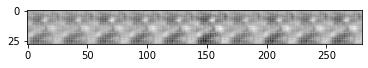

epoch: 92, d_loss: 0.8743599653244019, g_loss: 1.4791977405548096
epoch: 93, d_loss: 1.1906126737594604, g_loss: 1.286268711090088
epoch: 94, d_loss: 1.4055839776992798, g_loss: 0.8360928297042847
epoch: 95, d_loss: 1.3565915822982788, g_loss: 0.771759569644928
epoch: 96, d_loss: 1.3565078973770142, g_loss: 0.7506152391433716
epoch: 97, d_loss: 1.3715232610702515, g_loss: 0.7341182827949524
epoch: 98, d_loss: 1.374771237373352, g_loss: 0.7295642495155334
epoch: 99, d_loss: 1.3664281368255615, g_loss: 0.7320385575294495
epoch: 100, d_loss: 1.3597674369812012, g_loss: 0.7436009645462036


In [8]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()